In [1]:
import pathlib
import random
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
ROOT_PATH = pathlib.Path("images")
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {DEVICE}")
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
NUM_EPOCHS = 20
LOG_DIR = "./runs/pokemon_augmented_experiment"
MODEL_SAVE_PATH = "./pokemon_cnn_augmented.pth"

Using device: cpu


In [3]:
class PokemonImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [4]:
def build_train_test_datasets(root_dir: pathlib.Path, img_size=(64, 64), split_ratio=0.8):
    base_transforms = T.Compose([
        T.Resize(img_size),
        T.ToTensor()
    ])
    # трансформации с аугментацией (только для части train)
    aug_transforms = T.Compose([
        T.Resize(img_size),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=15),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.ToTensor()
    ])

    class_names = sorted([d.name for d in root_dir.iterdir() if d.is_dir()])

    train_paths = []
    train_labels = []
    test_paths = []
    test_labels = []

    for cls_idx, cls_name in enumerate(class_names):
        cls_folder = root_dir / cls_name
        images = [p for p in cls_folder.iterdir() if p.suffix.lower() in {".png", ".jpg", ".jpeg"}]

        if len(images) == 0:
            continue

        random.shuffle(images)

        if len(images) <= 2:
            # все изображения для этого класса идут в train
            for p in images:
                train_paths.append(p)
                train_labels.append(cls_idx)
        else:
            split_index = int(len(images) * split_ratio)
            split_index = max(split_index, 1)  # минимум 1 в train
            # если split_index == len(images), то убираем хотя бы 1 в test
            if split_index >= len(images):
                split_index = len(images) - 1

            for p in images[:split_index]:
                train_paths.append(p)
                train_labels.append(cls_idx)
            for p in images[split_index:]:
                test_paths.append(p)
                test_labels.append(cls_idx)

    # без аугментации (base train)
    train_base_dataset = PokemonImageDataset(train_paths, train_labels, transform=base_transforms)
    # с аугментацией (augmented train)
    train_augmented_dataset = PokemonImageDataset(train_paths, train_labels, transform=aug_transforms)
    # объединяем оба, чтобы train стал в 2 раза больше
    train_dataset = ConcatDataset([train_base_dataset, train_augmented_dataset])

    # test dataset (только базовые трансформации)
    test_dataset = PokemonImageDataset(test_paths, test_labels, transform=base_transforms)

    return {"train": train_dataset, "test": test_dataset}, class_names

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        input_h, input_w = IMG_SIZE
        flattened_features = 64 * (input_h // 4) * (input_w // 4)

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(flattened_features, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
def train_model(model, loaders, device, epochs, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    writer = SummaryWriter(LOG_DIR)

    history = {k: [] for k in
               ["train_loss", "train_acc", "train_prec", "train_rec",
                "val_loss", "val_acc", "val_prec", "val_rec"]}

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss, y_true_tr, y_pred_tr = 0.0, [], []

        for imgs, lbls in loaders["train"]:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            y_true_tr.extend(lbls.cpu().numpy())
            y_pred_tr.extend(outputs.argmax(1).cpu().numpy())

        # метрики train
        train_loss /= len(loaders["train"].dataset)
        train_acc = accuracy_score(y_true_tr, y_pred_tr)
        train_prec = precision_score(y_true_tr, y_pred_tr,
                                     average="macro", zero_division=0)
        train_rec = recall_score(y_true_tr, y_pred_tr,
                                 average="macro", zero_division=0)

        model.eval()
        val_loss, y_true_val, y_pred_val = 0.0, [], []

        with torch.no_grad():
            for imgs, lbls in loaders["test"]:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)

                val_loss += loss.item() * imgs.size(0)
                y_true_val.extend(lbls.cpu().numpy())
                y_pred_val.extend(outputs.argmax(1).cpu().numpy())

        val_loss /= len(loaders["test"].dataset)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_prec = precision_score(y_true_val, y_pred_val,
                                   average="macro", zero_division=0)
        val_rec = recall_score(y_true_val, y_pred_val,
                               average="macro", zero_division=0)

        writer.add_scalar("Train/Loss", train_loss, epoch)
        writer.add_scalar("Train/Accuracy", train_acc, epoch)
        writer.add_scalar("Train/Precision", train_prec, epoch)
        writer.add_scalar("Train/Recall", train_rec, epoch)

        writer.add_scalar("Val/Loss", val_loss, epoch)
        writer.add_scalar("Val/Accuracy", val_acc, epoch)
        writer.add_scalar("Val/Precision", val_prec, epoch)
        writer.add_scalar("Val/Recall", val_rec, epoch)

        print(f"Эпоха {epoch:2d}/{epochs} — "
              f"Train: loss {train_loss:.4f}, acc {train_acc:.4f}, "
              f"prec {train_prec:.4f}, rec {train_rec:.4f} | "
              f"Val: loss {val_loss:.4f}, acc {val_acc:.4f}, "
              f"prec {val_prec:.4f}, rec {val_rec:.4f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_prec"].append(train_prec)
        history["train_rec"].append(train_rec)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_prec"].append(val_prec)
        history["val_rec"].append(val_rec)

    writer.close()
    return history

In [12]:
def predict_dataset(model, dataset, device):
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    all_preds = []
    all_true = []
    all_images = []

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(lbls.numpy())
            all_images.append(imgs.cpu())

    images_tensor = torch.cat(all_images, dim=0)
    return images_tensor, np.array(all_preds), np.array(all_true)

In [13]:
def display_predictions(images_tensor, preds, trues, class_list, show_correct=True, n=10):
    mask = (preds == trues) if show_correct else (preds != trues)
    indices = np.where(mask)[0]
    if len(indices) == 0:
        print("Нет доступных примеров для отображения.")
        return

    chosen = np.random.choice(indices, size=min(n, len(indices)), replace=False)
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(chosen):
        img = images_tensor[idx].numpy().transpose(1, 2, 0)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"P: {class_list[preds[idx]]}\nT: {class_list[trues[idx]]}")
        plt.axis("off")

    title = "Правильные предсказания" if show_correct else "Ошибочные предсказания"
    plt.suptitle(title)
    plt.show()

Train (без аугментации): 2073
Train (с аугментацией): 4146
Test: 430
Эпоха  1/20 — Train: loss 6.8100, acc 0.0017, prec 0.0003, rec 0.0011 | Val: loss 6.7938, acc 0.0047, prec 0.0002, rec 0.0040
Эпоха  2/20 — Train: loss 6.7771, acc 0.0019, prec 0.0000, rec 0.0012 | Val: loss 6.5890, acc 0.0093, prec 0.0003, rec 0.0079
Эпоха  3/20 — Train: loss 6.4095, acc 0.0169, prec 0.0063, rec 0.0113 | Val: loss 5.7671, acc 0.0442, prec 0.0108, rec 0.0405
Эпоха  4/20 — Train: loss 5.4866, acc 0.0543, prec 0.0316, rec 0.0428 | Val: loss 5.0385, acc 0.1000, prec 0.0376, rec 0.0817
Эпоха  5/20 — Train: loss 4.5035, acc 0.1257, prec 0.1013, rec 0.1151 | Val: loss 4.7343, acc 0.1651, prec 0.1033, rec 0.1357
Эпоха  6/20 — Train: loss 3.7052, acc 0.2289, prec 0.2236, rec 0.2280 | Val: loss 4.5557, acc 0.1721, prec 0.1036, rec 0.1338
Эпоха  7/20 — Train: loss 3.1093, acc 0.3239, prec 0.3275, rec 0.3225 | Val: loss 4.5469, acc 0.2000, prec 0.1362, rec 0.1603
Эпоха  8/20 — Train: loss 2.6764, acc 0.3999, pre

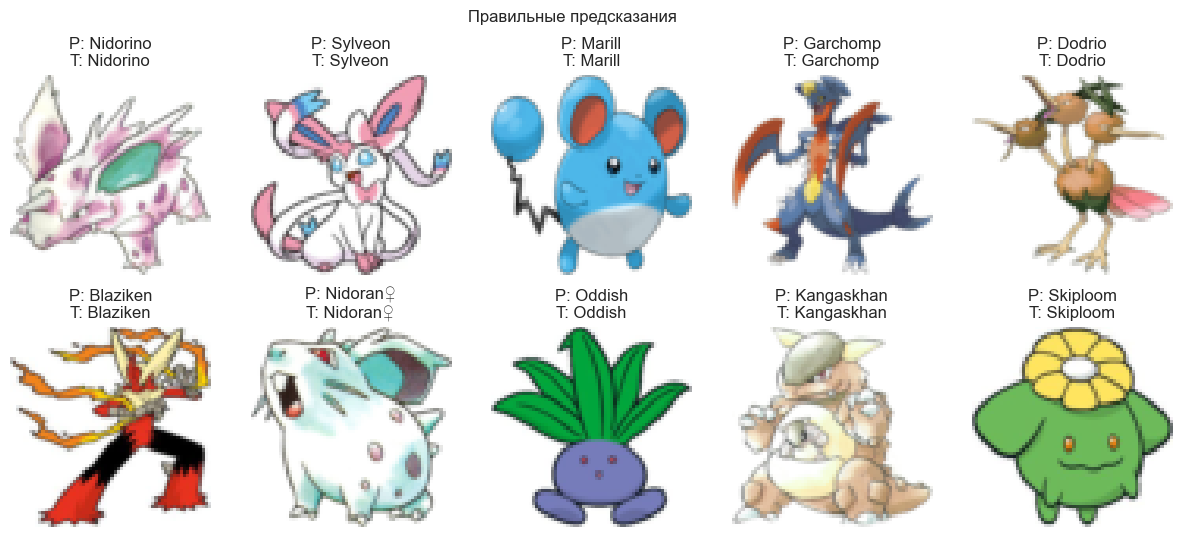

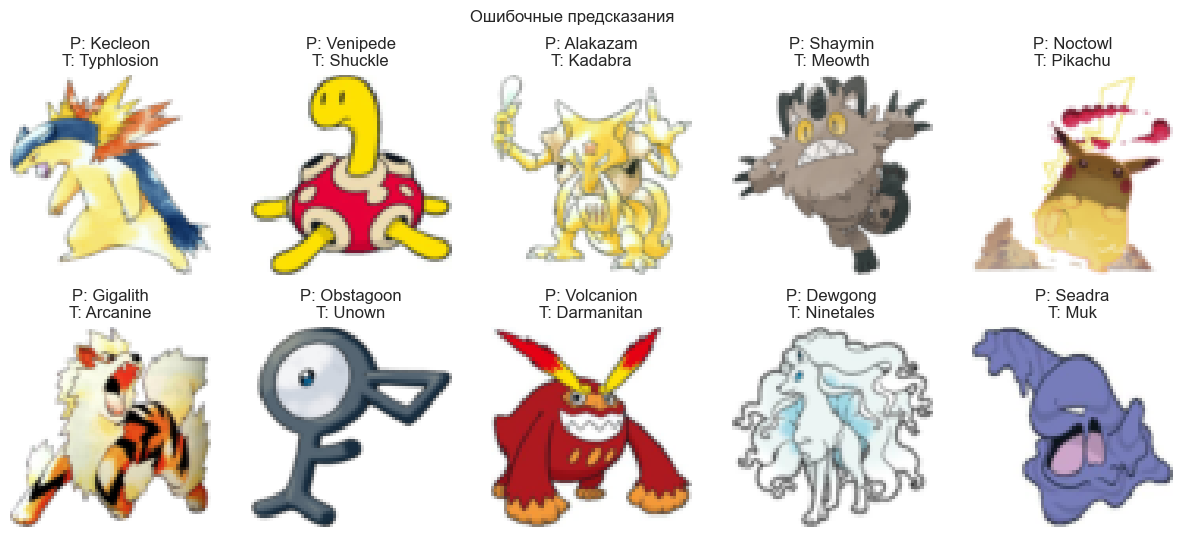

In [14]:
datasets_dict, class_names = build_train_test_datasets(ROOT_PATH, IMG_SIZE, split_ratio=0.8)
base_train_len = len(datasets_dict["train"].datasets[0])
aug_train_len = len(datasets_dict["train"])
test_len = len(datasets_dict["test"])

print(f"Train (без аугментации): {base_train_len}")
print(f"Train (с аугментацией): {aug_train_len}")
print(f"Test: {test_len}")

data_loaders = {
    "train": DataLoader(datasets_dict["train"], batch_size=BATCH_SIZE, shuffle=True),
    "test": DataLoader(datasets_dict["test"], batch_size=BATCH_SIZE, shuffle=False),
}

model = SimpleCNN(num_classes=len(class_names)).to(DEVICE)
history = train_model(model, data_loaders, DEVICE, epochs=NUM_EPOCHS)
torch.save(model.state_dict(), MODEL_SAVE_PATH)

loaded_model = SimpleCNN(num_classes=len(class_names))
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(DEVICE)

imgs_all, preds_all, trues_all = predict_dataset(loaded_model, datasets_dict["test"], DEVICE)

accuracy = accuracy_score(trues_all, preds_all)
precision = precision_score(trues_all, preds_all, average="macro", zero_division=0)
recall_val = recall_score(trues_all, preds_all, average="macro", zero_division=0)
print(f"Точность на тесте: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall_val:.4f}")

display_predictions(imgs_all, preds_all, trues_all, class_names, show_correct=True, n=10)
display_predictions(imgs_all, preds_all, trues_all, class_names, show_correct=False, n=10)

# Выводы:
1) Без аугментации результаты были совсем плохие, но даже с аугментацией не получается получить accuracy>0.33. Горизонтальный флип и мелкие вращения полезны, но для покемонов, у которых обычно есть конкретный верх и низ и уникальный фон, они не дают сильного разнообразия.
2) Не очень высокое значение accuracy свидетельствует о том, что датасет слишком маленький, для улучшения результатов необходим больший датасет.
3) Метрики показывают, что есть переобучение, тк разрыв (train – val): к концу обучения = 0.31.
val_loss падает лишь до 4.45.
Precision / Recall заведомо ниже accuracy, т.е. модель делает много неуверенных предсказаний и путает между несколькими классами.
4) Посмотрим на графики accuracy, precision, recall (см в файлах train.png, val.png): для train у accuracy / precision / recall — плавный S-образный рост до 0.65 / 0.71 / 0.69.
Это означает, что модель хорошо запоминает тренировочные примеры.
Loss падает экспоненциально, достигая значения примерно 1.4, что тоже подтверждает хорошее запоминание.
Для validation: accuracy растёт лишь до 0.31. График ровный без осцилляций — датасет маленький, поэтому validate-батчи каждый раз почти одинаковы.
Precision / Recall (0.23 / 0.26) отстают от accuracy; значит модель угадывает правильный класс чаще, чем она уверена в нём (precision ниже).
Val-Loss сначала падает, но после 12-й эпохи перестаёт улучшаться (минимум = 4.4), затем постепенно растёт => можно было бы сделать early stopping примерно на 13 эпохе.

In [15]:
def calculate_mean_images(root_dir: pathlib.Path):
    counts = []
    for subfolder in sorted(root_dir.iterdir()):
        if not subfolder.is_dir():
            continue
        images = [f for f in subfolder.iterdir() if f.suffix.lower() in {".png", ".jpg", ".jpeg"}]
        counts.append(len(images))
    if not counts:
        print("Нет папок с изображениями.")
        return
    avg_count = sum(counts) / len(counts)
    print(f"Среднее число изображений на класс: {avg_count:.2f}")
    print(f"Минимум: {min(counts)}, Максимум: {max(counts)}")

In [16]:
calculate_mean_images(ROOT_PATH)

Среднее число изображений на класс: 2.79
Минимум: 1, Максимум: 8


Видим, что распределение по классам неравномерное и в среднем очень небольшое кол-во картинок на каждого покемона.
В начале вообще была низкая accuracy, потом стала ловить классы, где 1-2 картинки и все отправлять в train

Выбрано 15 случайных изображений из теста (индексы внутри test_dataset):
[235, 311, 230, 2, 7, 284, 336, 411, 216, 343, 63, 190, 313, 88, 156]

Index 235:  Предсказанный класс = Moltres,  Истинный класс = Moltres
Максимальная вероятность = 0.9986


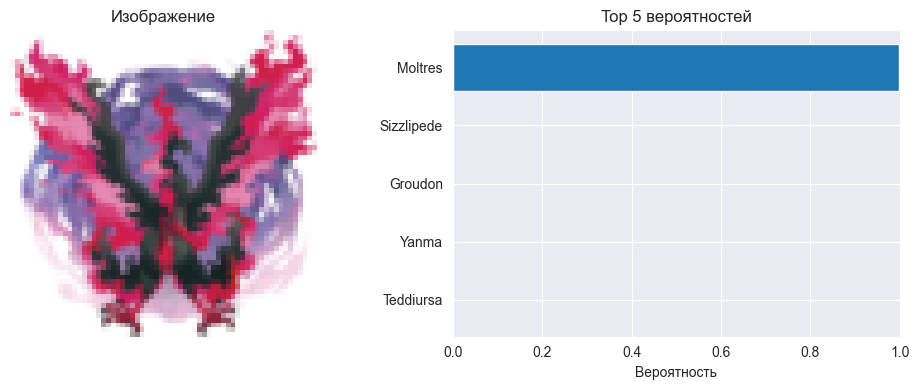


Index 311:  Предсказанный класс = Reshiram,  Истинный класс = Reshiram
Максимальная вероятность = 0.1687


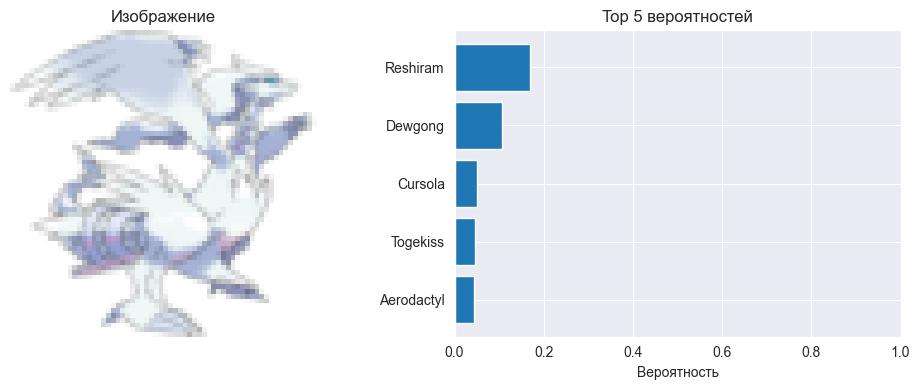


Index 230:  Предсказанный класс = Miltank,  Истинный класс = Miltank
Максимальная вероятность = 0.9350


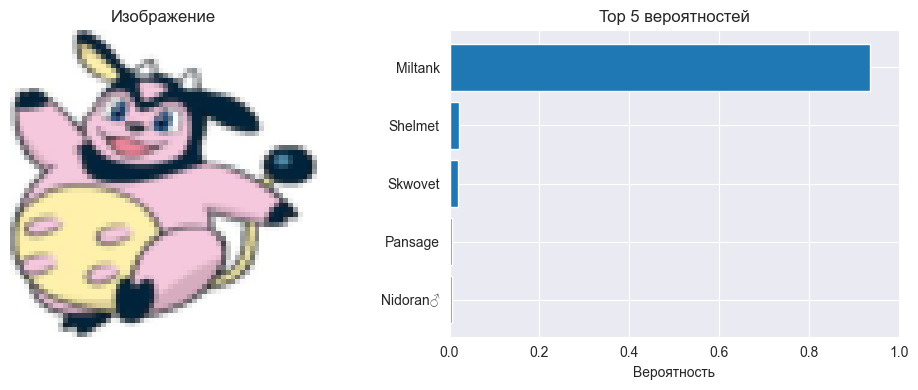


Index 2:  Предсказанный класс = Absol,  Истинный класс = Absol
Максимальная вероятность = 0.7522


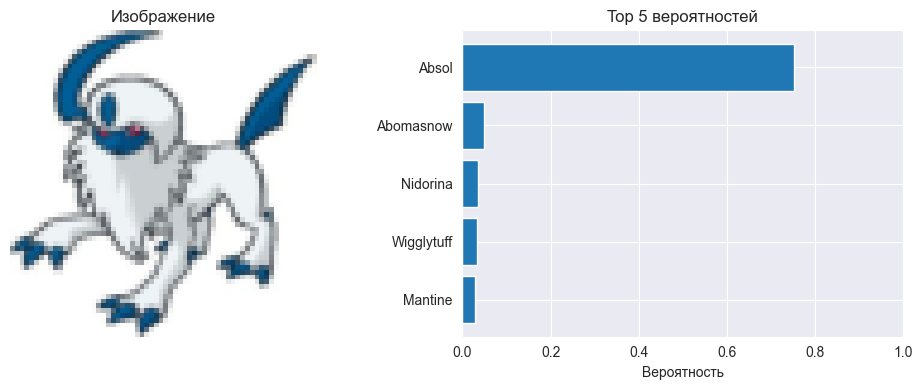


Index 7:  Предсказанный класс = Aipom,  Истинный класс = Aipom
Максимальная вероятность = 0.3135


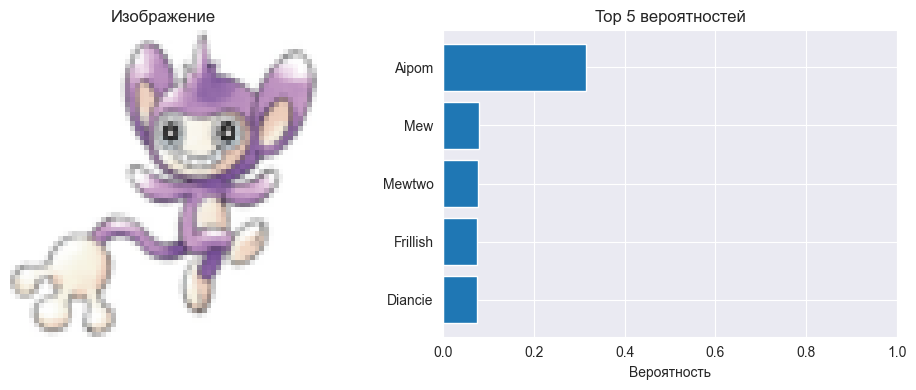


Index 284:  Предсказанный класс = Poliwhirl,  Истинный класс = Poliwhirl
Максимальная вероятность = 0.9730


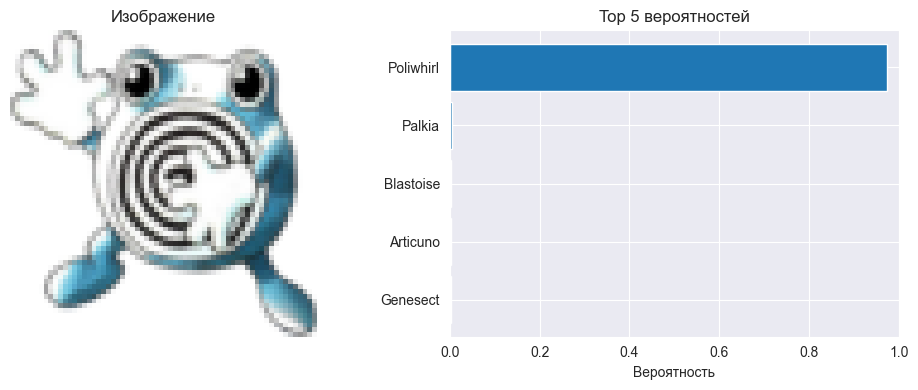


Index 336:  Предсказанный класс = Venipede,  Истинный класс = Shuckle
Максимальная вероятность = 0.7823


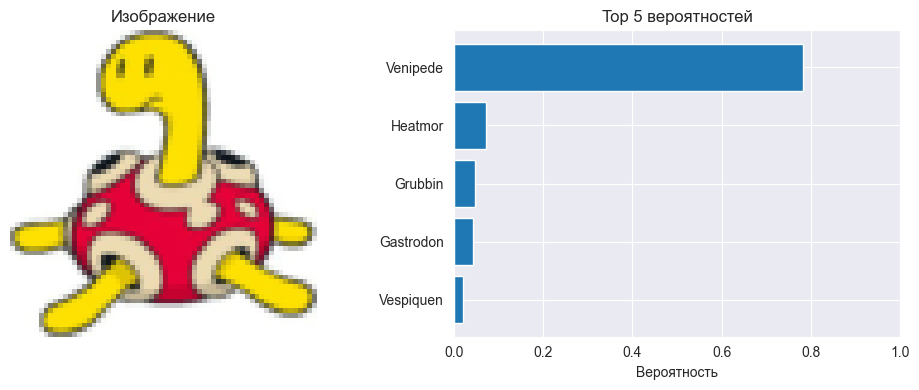


Index 411:  Предсказанный класс = Regice,  Истинный класс = Wobbuffet
Максимальная вероятность = 0.4750


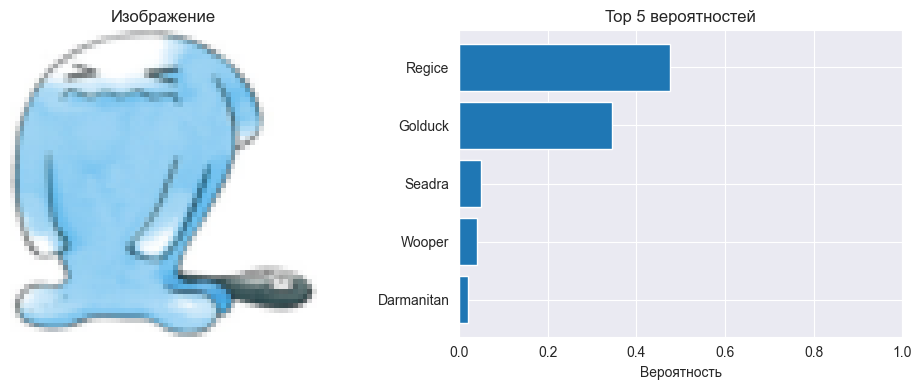


Index 216:  Предсказанный класс = Inteleon,  Истинный класс = Marshadow
Максимальная вероятность = 0.9303


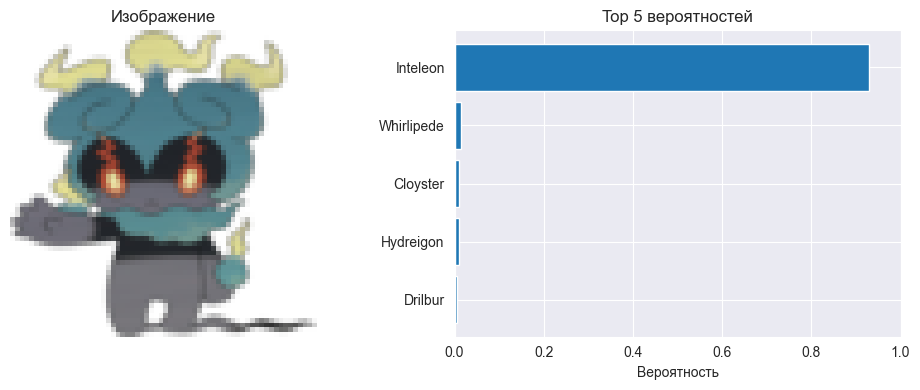


Index 343:  Предсказанный класс = Mienfoo,  Истинный класс = Slowpoke
Максимальная вероятность = 0.2235


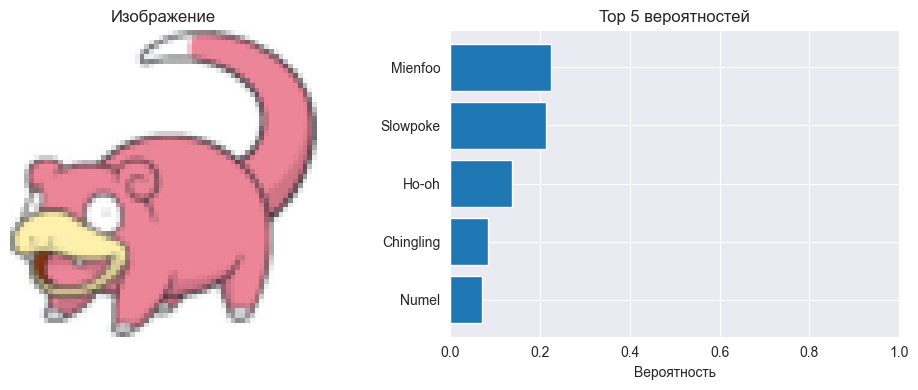


Index 63:  Предсказанный класс = Zangoose,  Истинный класс = Darmanitan
Максимальная вероятность = 0.9496


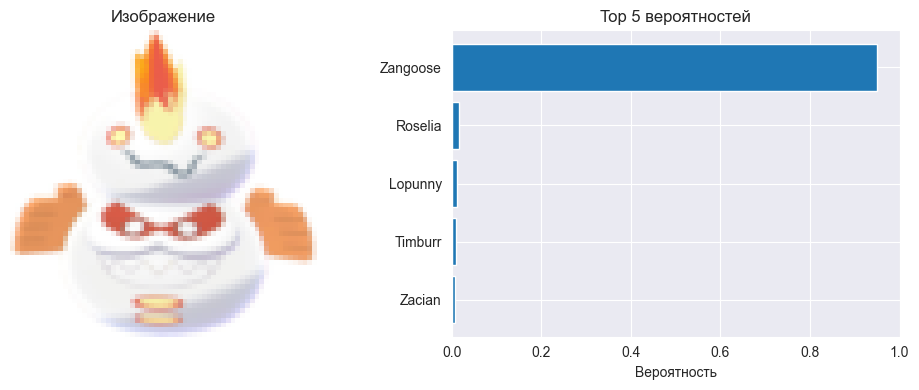


Index 190:  Предсказанный класс = Ledyba,  Истинный класс = Ledyba
Максимальная вероятность = 0.9965


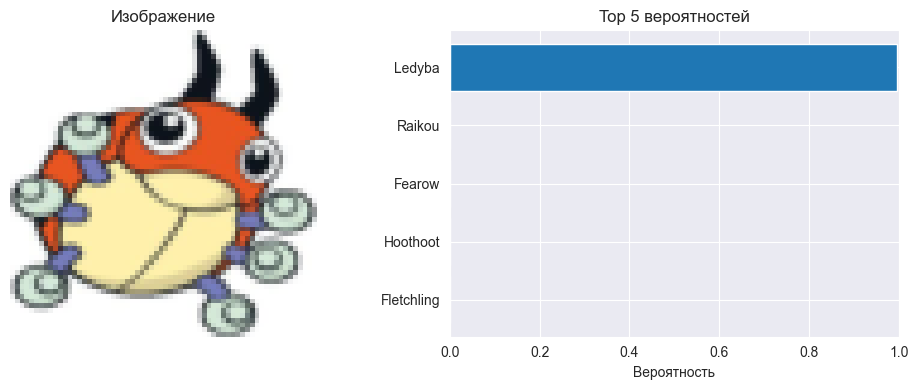


Index 313:  Предсказанный класс = Rhyhorn,  Истинный класс = Rhyhorn
Максимальная вероятность = 0.9787


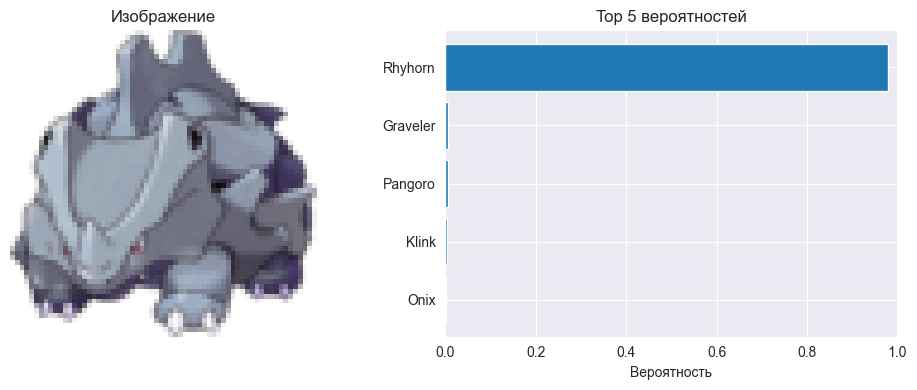


Index 88:  Предсказанный класс = Sandygast,  Истинный класс = Eevee
Максимальная вероятность = 0.2431


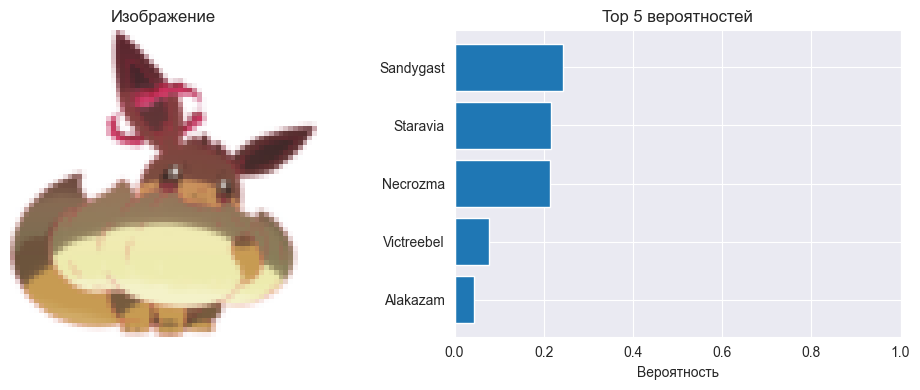


Index 156:  Предсказанный класс = Horsea,  Истинный класс = Horsea
Максимальная вероятность = 0.9598


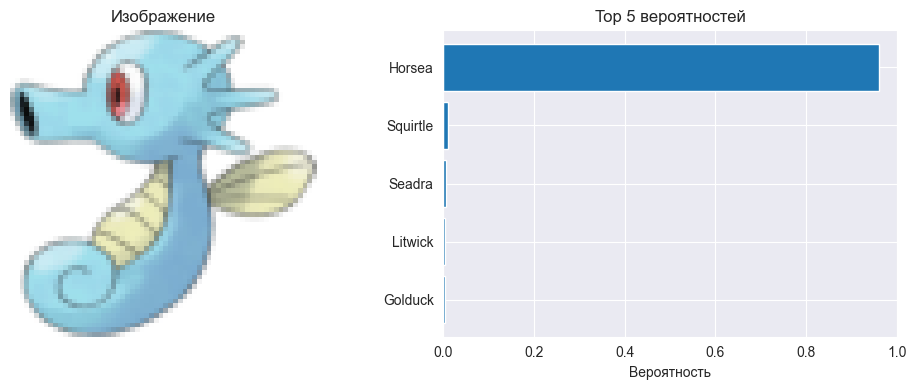

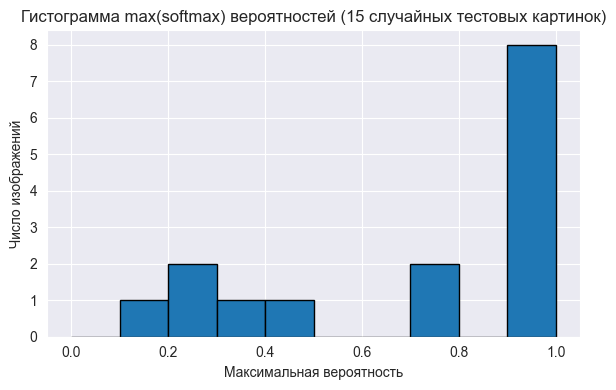

In [20]:
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np


# функция для визуализации одной картинки + её вероятностей
def visualize_probs(img_tensor, class_list, prob_vector, topk=5):
    img_np = img_tensor.numpy().transpose(1, 2, 0)  # [H, W, 3]
    # берём индексы topk вероятностей
    topk_idx = np.argsort(prob_vector)[-topk:][::-1]  # от самой большой к меньшей
    topk_probs = prob_vector[topk_idx]
    topk_names = [class_list[i] for i in topk_idx]

    fig, (ax_img, ax_bar) = plt.subplots(1, 2, figsize=(10, 4))
    ax_img.imshow(img_np)
    ax_img.axis("off")
    ax_img.set_title("Изображение")

    bar_names = topk_names[::-1]
    bar_probs = topk_probs[::-1]
    y_pos = np.arange(len(bar_names))
    ax_bar.barh(y_pos, bar_probs, align="center")
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels(bar_names)
    ax_bar.set_xlim(0, 1)
    ax_bar.set_xlabel("Вероятность")
    ax_bar.set_title(f"Top {topk} вероятностей")

    plt.tight_layout()
    plt.show()


# берём 15 случайных индексов из тестового набора
num_test = len(datasets_dict["test"])
sample_size = min(15, num_test)
random_indices = random.sample(range(num_test), k=sample_size)

# для каждого индекса: получаем тензор изображения, выводим его + вероятности
print(f"Выбрано {sample_size} случайных изображений из теста (индексы внутри test_dataset):")
print(random_indices)

for idx in random_indices:
    # получаем из test_dataset: img_tensor, true_label
    img_tensor, true_label = datasets_dict["test"][idx]
    # делаем батч и отправляем на устройство
    img_batch = img_tensor.unsqueeze(0).to(DEVICE)  # shape [1, 3, H, W]
    with torch.no_grad():
        logits = model(img_batch)  # shape [1, num_classes]
        probs = F.softmax(logits, dim=1).cpu().numpy().flatten()  # shape [num_classes]

    pred_label = np.argmax(probs)
    print(
        f"\nIndex {idx}:  Предсказанный класс = {class_names[pred_label]},  Истинный класс = {class_names[true_label]}")
    print(f"Максимальная вероятность = {probs[pred_label]:.4f}")

    visualize_probs(img_tensor.cpu(), class_names, probs, topk=5)

# построим гистограмму распределения max-вероятностей по этой выборке
max_probs_samples = []
for idx in random_indices:
    img_tensor, _ = datasets_dict["test"][idx]
    img_batch = img_tensor.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        logits = model(img_batch)
        probs = F.softmax(logits, dim=1)
        max_p = torch.max(probs, dim=1)[0].item()
    max_probs_samples.append(max_p)

plt.figure(figsize=(6, 4))
plt.hist(max_probs_samples, bins=10, range=(0, 1), edgecolor='black')
plt.title("Гистограмма max(softmax) вероятностей (15 случайных тестовых картинок)")
plt.xlabel("Максимальная вероятность")
plt.ylabel("Число изображений")
plt.tight_layout()
plt.show()

Видим, что половина всех вероятностей близка к 1. Однако, помним, что accuracy был примерно 0.32. Видим, что из вероятностей, близких к 1, 3 предсказания оказались неверными, что говорит о том, что модель не научилась обобщать, а просто запомнила мелкие детали => переобучение.
Вероятности в районе 0.1-0.4 говорят о том, что на этих покемонах модель сомневалась, всего 2 результата при низкой вероятности оказались верными. Скорее всего такой результат получаем из-за того, что некоторые покемоны сильно похожи друг на друга + у нас маленький датасет => недостаточно данных для тренировки, модель просто запомнила train, но, опять же, не научилась обобщать.